# **Clasificación de las diferentes etapas de maduración de las fresas**


**Trabajo Final Bootcamp de inteligencia artificial**

**Presentado por:** Fabian Paredes

**Tutor:** Andres Felipe Escallón

**Fecha:** 25 Mayo 2024


## **Objetivos:**

* Identificar las distintas etapas de maduración de las fresas.

* Clasificar las diferente etapas de maduración de la fresa

## **Metodología:**

En primer lugar, es fundamental identificar las distintas etapas de maduración de las fresas. Estas pueden variar desde el estado inmaduro hasta el completamente maduro. Las etapas comunes incluyen:

1. Verde inmaduro: En esta etapa, la fresa tiene un color verde intenso y no presenta señales de enrojecimiento.
2. Maduración incipiente: La fresa comienza a adquirir tonos rojizos en algunas áreas, pero aún conserva parte de su color verde.
3. Madurez intermedia: La fresa muestra una combinación de rojo y verde, indicando que está en proceso de maduración.
4. Madurez completa: En esta etapa, la fresa adquiere un color rojo brillante en toda su superficie y está lista para su consumo.
5. Sobremaduración: La fresa comienza a mostrar signos de deterioro, como manchas marrones y una textura suave.

Una vez identificadas estas etapas, se procederá a obtener la relación de colores RGB de las fresas en cada una de ellas. Esto se realizará mediante el uso de un dispositivo de captura de imágenes, como una cámara, y software de análisis de imágenes que permita determinar los valores de rojo, verde y azul presentes en la superficie de la fresa en cada etapa de maduración.

Este estudio proporcionará información valiosa sobre la evolución del color de las fresas durante su proceso de maduración, lo que puede ser útil para la industria agrícola en términos de optimización de la cosecha y control de calidad.

## **Clasificación de fresas**

### **Importación de librerías**

In [59]:
from google.colab import drive
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### **Carga de datos**

In [60]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
dataset_path = "/content/drive/MyDrive/Fresa/strawberry/strawberryDataset"

**Importamos libreria de kaggle [strawberry-dataset](https://www.kaggle.com/datasets/abdulbasit31/strawberry-dataset/data)**

---

In [62]:
imageSize=(256, 256)
batch_size = 32
split = 0.2
seed = 123

def get_image_dataset(directory, subset=None,validation_split=None):
  return tf.keras.utils.image_dataset_from_directory(
      directory,
      validation_split=validation_split,
      subset=subset,
      seed=seed,
      image_size=imageSize,
      batch_size=batch_size)

training_ds = get_image_dataset(dataset_path, "training", validation_split=split)

validation_ds = get_image_dataset(dataset_path, "validation", validation_split=split)


Found 521 files belonging to 2 classes.
Using 417 files for training.
Found 521 files belonging to 2 classes.
Using 104 files for validation.


In [63]:
class_names = training_ds.class_names
num_classes = len(class_names)
print(num_classes,class_names)

2 ['Pickable', 'UnPickable']


### **Visualización de datos**

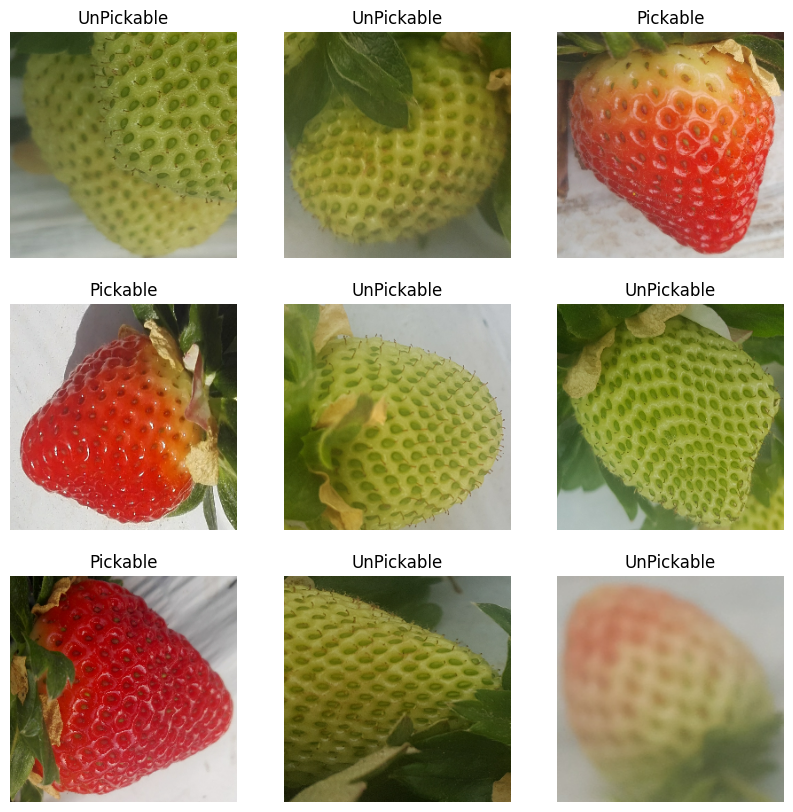

In [64]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  break


***Forma del conjunto de datos de entrenamiento***

In [65]:
for image_batch, labels_batch in training_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### **Aumento del conjunto de datos**

El aumento de datos se realiza con el fin de que, al momento del entrenamiento, el modelo aprenda sobre las características de las imágenes en lugar de memorizar las imágenes que se le proporcionan. En este caso, las imágenes se modificaron de la siguiente manera:

- Traslados horizontales y verticales
- Rotación aleatoria
- Cambio aleatorio del brillo
- Cambio aleatorio del contraste
- Cambio aleatorio del zoom de la imagen

In [66]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical",input_shape=(256, 256, 3)),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
  tf.keras.layers.RandomContrast(factor=0.2),
  tf.keras.layers.RandomZoom(height_factor=0.3,width_factor=0.3,fill_mode='reflect')
],name="data_augmentation")

rescale = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255)
])


In [67]:
#mejora del rendimiento
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Entrenamiento del modelo**

#### **Modelo**

El modelo está conformado por redes neuronales y se distribuye de la siguiente manera:

- Tres redes convolucionales con 32, 64 y 128 filtros respectivamente, con tamaño de filtro de 3 filas por 3 columnas y función de activación ReLU.
- Tres capas de max pooling al final de cada CNN con tamaño de 2 filas por 2 columnas.
- Dropout con el 30% de las neuronas.
- Una capa para aplanar las imágenes.
- Cuatro capas densas de 128, 64, 32 y 16 neuronas respectivamente, con función de activación ReLU.
- Una capa densa de salida con dos neuronas.

In [70]:
model = tf.keras.models.Sequential([
    data_augmentation,
    rescale,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(num_classes),
])

En la compilación del modelo se usa las siguiente caracteristicas:

- Optimizador: Adam
- Función de pérdida: sparse categorical crossentropy
- Métricas: accuracy (exactitud)

In [71]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 sequential_11 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 62, 62, 64)      

Para el ajuste del modelo se usa un total de 50 epocas

In [72]:
# Epocas
epochs = 50

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs,
    )

Epoch 1/50
14/14 [==============================] - 7s 188ms/step - loss: 0.8389 - accuracy: 0.7530 - val_loss: 0.2550 - val_accuracy: 0.9519
Epoch 2/50
14/14 [==============================] - 2s 112ms/step - loss: 0.2255 - accuracy: 0.9472 - val_loss: 0.0570 - val_accuracy: 0.9808
Epoch 3/50
14/14 [==============================] - 2s 109ms/step - loss: 0.0944 - accuracy: 0.9640 - val_loss: 0.0327 - val_accuracy: 0.9808
Epoch 4/50
14/14 [==============================] - 2s 108ms/step - loss: 0.0692 - accuracy: 0.9784 - val_loss: 0.0375 - val_accuracy: 0.9904
Epoch 5/50
14/14 [==============================] - 2s 110ms/step - loss: 0.0552 - accuracy: 0.9760 - val_loss: 0.0260 - val_accuracy: 1.0000
Epoch 6/50
14/14 [==============================] - 2s 109ms/step - loss: 0.0762 - accuracy: 0.9736 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 7/50
14/14 [==============================] - 2s 109ms/step - loss: 0.0739 - accuracy: 0.9712 - val_loss: 0.0331 - val_accuracy: 0.9808
Epoch 

#### **Evaluación del modelo**

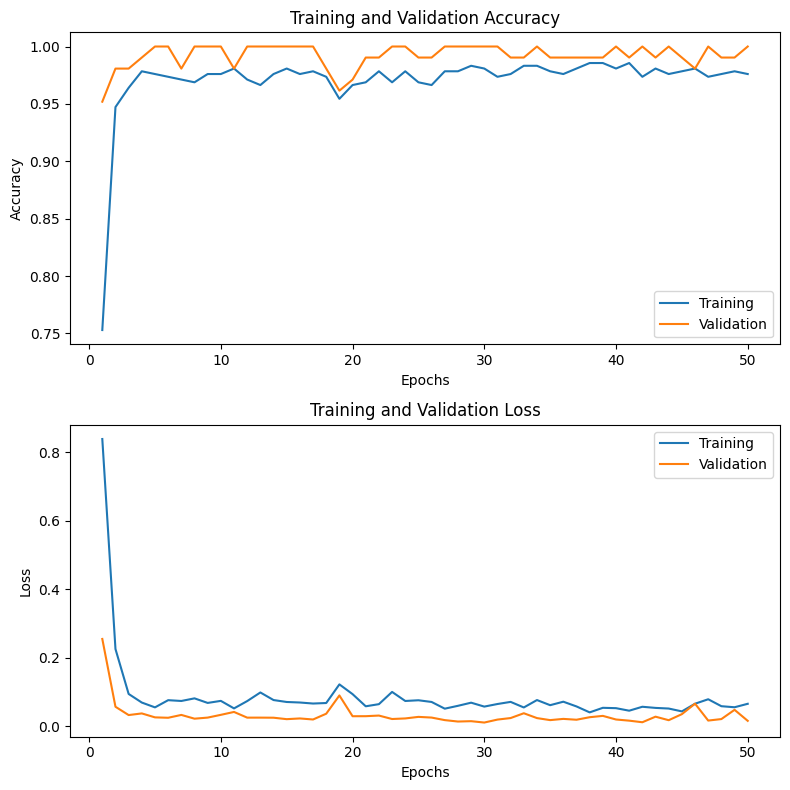

In [73]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs_range = range(1, len(loss) + 1)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 8), sharex=False, sharey=False)

ax1.plot(epochs_range, accuracy, label='Training')
ax1.plot(epochs_range, val_accuracy, label='Validation')
ax1.legend()
ax1.set_title("Training and Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

ax2.plot(epochs_range, loss, label='Training')
ax2.plot(epochs_range, val_loss, label='Validation')
ax2.legend()
ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

fig.tight_layout()

plt.show()



In [74]:

def get_predicted_true(ds):
  y_pred = np.array([])
  y_true = np.array([])

  for image_batch, label_batch in ds:
    pred = model.predict(image_batch)
    y_pred = pred if len(y_pred) == 0 else np.concatenate((y_pred, pred))

    y_true = label_batch if len(y_true) == 0 else np.concatenate((y_true, label_batch))

  y_pred = y_pred.argmax(axis=1)

  return y_pred, y_true

y_pred, y_true = get_predicted_true(validation_ds)
print(y_pred.shape,y_true.shape)

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 125ms/step
(104,) (104,)


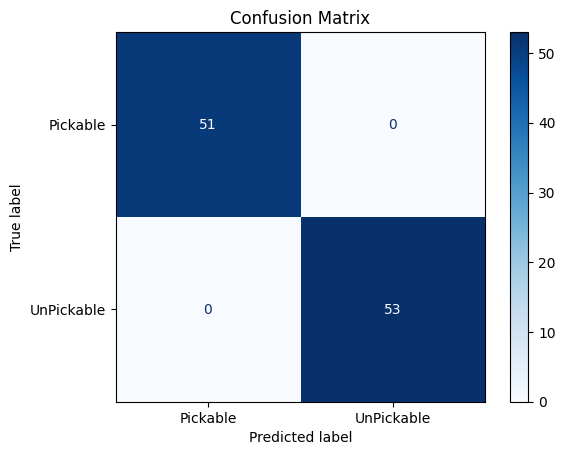

[[51  0]
 [ 0 53]]


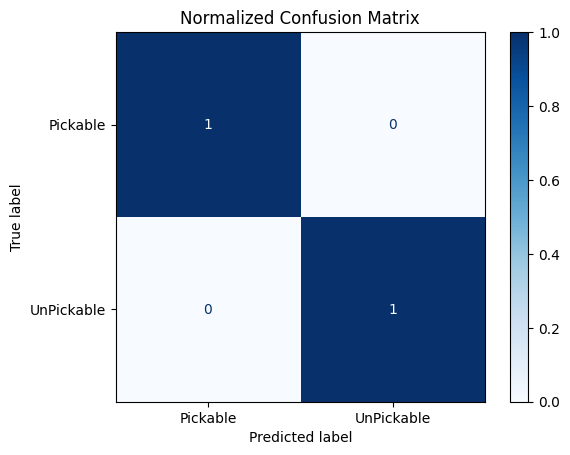

[[1. 0.]
 [0. 1.]]


In [75]:
def plot_confusion_matrix(y_true, y_predicted, class_names, normalize = None, title = "Confusion Matrix"):
  disp = ConfusionMatrixDisplay.from_predictions(
      y_true=y_true,
      y_pred=y_predicted,
      display_labels=class_names,
      cmap=plt.cm.Blues,
      normalize=normalize)

  disp.ax_.set_title(title)

  plt.show()

  return disp.confusion_matrix

mc = plot_confusion_matrix(y_true=y_true,y_predicted=y_pred, class_names=class_names)
print(mc)
mc = plot_confusion_matrix(y_true=y_true,y_predicted=y_pred, class_names=class_names,normalize='true',title='Normalized Confusion Matrix')
print(mc)

#### **Evaluación de modelo con datos externos**

In [76]:
test_path = '/content/drive/MyDrive/Fresa/strawberry/test'

Found 13 files belonging to 2 classes.


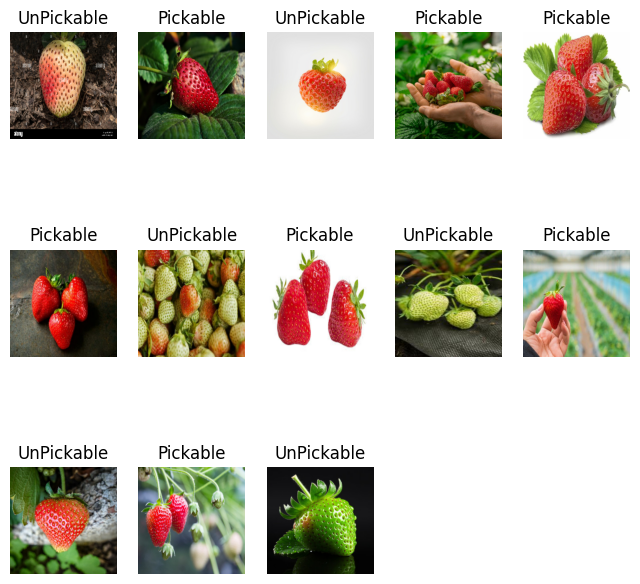

In [106]:
test_ds = get_image_dataset(test_path)

plt.figure(figsize=(8, 8))
for images, labels in test_ds:
  lenImages = len(images)
  for i in range(lenImages):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  break

In [107]:
y_pred_test, y_true_test = get_predicted_true(test_ds)

print(y_pred_test.shape, y_true_test.shape)

1/1 [==============================] - 0s 25ms/step
(13,) (13,)


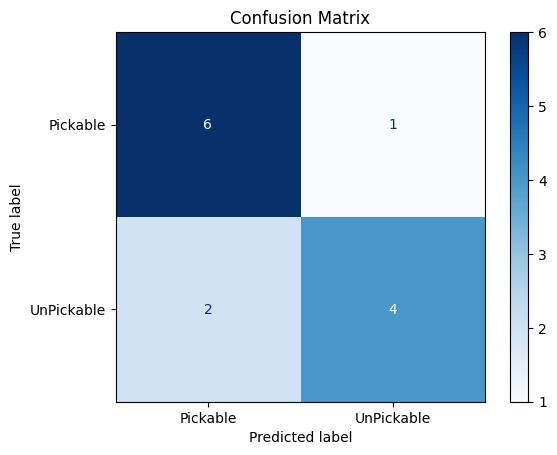

[[6 1]
 [2 4]]


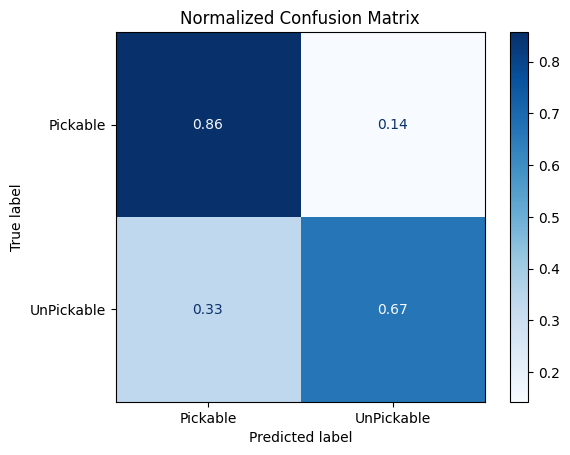

[[0.85714286 0.14285714]
 [0.33333333 0.66666667]]


In [108]:
mc = plot_confusion_matrix(y_true=y_true_test,y_predicted=y_pred_test, class_names=class_names)
print(mc)
mc = plot_confusion_matrix(y_true=y_true_test,y_predicted=y_pred_test, class_names=class_names,normalize='true',title='Normalized Confusion Matrix')
print(mc)

In [81]:
folder_model ='/content/drive/MyDrive/ModelsAI'
model_name = 'strawberries-model2.h5'

model.save(f'{folder_model}/{model_name}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [82]:
model_json = model.to_json()
with open(f'{folder_model}/strawberries-model2.json', 'w') as json_file:
    json_file.write(model_json)

## **Conclusiones**

- Debido a la falta de imágenes de fresas, solo se identificaron dos grupos grandes de fresas, lo que permitió realizar una clasificación preliminar entre cosechables y no cosechables.

- Se clasificaron las diferentes etapas de maduración de las fresas, pero el modelo presentó un mal ajuste clasificatorio debido a la insuficiencia de imágenes. Por ello, se utilizó un aumento de datos para mejorar la predicción. Sin embargo, el modelo muestra un ajuste rápido alrededor de las etapas 8 a 10, lo que influyó rápidamente en las predicciones finales, mostrando errores en la clasificación.